In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import unquote


dataFolder = '../Data/wikispeedia_paths-and-graph/'

#articles names
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
articlesSeries.columns= 'article'
articlesSeries.head(10)
print(articlesSeries.shape)

#the list of all links between articles
linksDf = pd.read_csv(dataFolder + 'links.tsv', skiprows= 11, sep = '\t')
linksDf.columns = ['linkSource', 'linkTarget']
linksDf['linkSource'] = linksDf['linkTarget'].map(lambda x : unquote(x, 'utf-8'))
linksDf['linkTarget'] = linksDf['linkTarget'].map(lambda x : unquote(x, 'utf-8'))
linksDf

#Hierarchical categories of all articles / Many articles have more than one cartegory, some article has no category. 
categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', skiprows=12, sep= '\t')
categoriesDf.columns = ['article', 'categories']
categoriesDf['article'] = categoriesDf['article'].map(lambda x : unquote(x,'utf-8'))


#Sucessful i.e finished Wikipedia paths.
#for paths_finishedDf FORMAT:   hashedIpAddress   timestamp   durationInSec   path   rating
paths_finishedDf = pd.read_csv(dataFolder + 'paths_finished.tsv',skiprows= 15, sep = '\t')
paths_finishedDf.columns = ['hashIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']

#Unsuccessful (i.e., unfinished) Wikispeedia paths
#for paths unfinished FORMAT:   hashedIpAddress   timestamp   durationInSec   path   target   type
paths_unfinishedDf = pd.read_csv(dataFolder + 'paths_unfinished.tsv',skiprows = 16, sep = '\t')
paths_unfinishedDf.columns = ['hashIpAddress', 'timestamp', 'durationInSec', 'path', 'target','type']



# The shortest-path distances between all pairs of articles, computed using the Floyd-Warshall algorithm.
'''shortestPath = pd.read_csv(dataFolder+'shortest-path-distance-matrix.txt', skiprows= 15)
print(shortestPath.shape)
shortestPath.columns = ['shortest_path', 'temp']
shortestPath = shortestPath['shortest_path']
shortestPathDf = pd.DataFrame(columns= articlesSeries)
shortestPath.apply(lambda x : str(x))
shortestPath.info
'''
#retrieve all possibles categories
categories = categoriesDf["categories"].str.split('.')
allCategories = []
for i in range(categories.shape[0]) : 
    for j in categories.iloc[i]:
        if j not in allCategories :
            allCategories.append(j)
allCategories = allCategories[1:]
allCategories


people_skin_color = pd.read_csv(dataFolder + 'people_with_skin_color.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : unquote(x, 'utf-8'))
people_skin_color.reset_index()
people_skin_color




(4604,)


,Category,People,Skin Color
0,subject.People.Historical_figures,Óengus I of the Picts,Blanc
1,subject.People.Historical_figures,Abbas I of Persia,Peau plus foncée
2,subject.People.Historical_figures,Adam Smith,Blanc
3,subject.People.Historical_figures,Adriaen van der Donck,Blanc
4,subject.People.Historical_figures,Agamemnon,Blanc
...,...,...,...
706,subject.People.Computing_People,Jimmy Wales,Blanc
707,subject.People.Computing_People,Linus Torvalds,Blanc
708,subject.People.Computing_People,Richard Stallman,Blanc
709,subject.People.Computing_People,Tim Berners-Lee,Blanc


In [27]:
from datetime import datetime
from urllib.parse import unquote
paths_finishedDf['timestamp'] = paths_finishedDf['timestamp'].map(lambda x : datetime.fromtimestamp(x,tz = None))
paths_finishedDf
#Evolution temporelle : est-ce que les hubs changent au cours du temps ?
#est ce que cette évolution est lié à des faits d'actualités ?
#on commence par trier par année



,hashIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,2012-08-12 08:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,2012-10-03 23:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,2010-02-08 08:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,2013-04-23 17:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,2013-07-04 00:26:54,110,14th_century;Europe;North_America;United_State...,NaN
...,...,...,...,...,...
51312,15a13a1d66ef5456,2012-10-03 04:23:35,66,Yagan;Ancient_Egypt;Civilization,NaN
51313,2ef7ac844cefda58,2011-03-16 06:42:18,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51314,12863abb7887f890,2013-11-22 05:42:52,228,Yagan;Australia;England;France;United_States;T...,NaN
51315,19f8284371753362,2011-02-27 08:42:47,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [28]:
paths_finished_by_time = paths_finishedDf[['timestamp', 'path']]
paths_finished_by_time['timestamp'] = paths_finished_by_time['timestamp'].map(lambda y : y.year)
paths_finished_by_time

/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_48151/1274029188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished_by_time['timestamp'] = paths_finished_by_time['timestamp'].map(lambda y : y.year)


,timestamp,path
0,2012,14th_century;Europe;Africa;Atlantic_slave_trad...
1,2012,14th_century;Niger;Nigeria;British_Empire;Slav...
2,2010,14th_century;Renaissance;Ancient_Greece;Greece
3,2013,14th_century;Italy;Roman_Catholic_Church;HIV;R...
4,2013,14th_century;Europe;North_America;United_State...
...,...,...
51312,2012,Yagan;Ancient_Egypt;Civilization
51313,2011,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...
51314,2013,Yagan;Australia;England;France;United_States;T...
51315,2011,Yarralumla%2C_Australian_Capital_Territory;Aus...


In [29]:
paths_finished_by_time = paths_finished_by_time.groupby(['timestamp'], as_index= True).apply(lambda x : x)
paths_finished_by_time

timestamp                                               path
timestamp                                                                    
2008      6           2008  14th_century;Time;Isaac_Newton;Light;Color;Rai...
          78          2008       Acceleration;Albert_Einstein;Germany;Dresden
          83          2008  Acceleration;Earth;United_Nations;United_State...
          109         2008  Achilles;Trojan_War;Italy;Great_Britain;Englan...
          138         2008  Achilles_tendon;Achilles;Trojan_War;Alexander_...
...                    ...                                                ...
2014      50728       2014  ZX_Spectrum;United_Kingdom;<;Commodore_64;Unit...
          50804       2014                      Zulu;AK-47;Chromium;Aluminium
          51087       2014  Hubble%27s_law;Albert_Einstein;Israel;Argentin...
          51116       2014  John_Seigenthaler%2C_Sr.;Washington%2C_D.C.;Wo...
          51278       2014  Timken_1111;Pennsylvania_Railroad;Gold_standar...

[51317 rows x 2 columns]

In [30]:
paths_finished_by_time.index = [index[0] for index in paths_finished_by_time.index]
paths_finished_by_time

,timestamp,path
2008,2008,14th_century;Time;Isaac_Newton;Light;Color;Rai...
2008,2008,Acceleration;Albert_Einstein;Germany;Dresden
2008,2008,Acceleration;Earth;United_Nations;United_State...
2008,2008,Achilles;Trojan_War;Italy;Great_Britain;Englan...
2008,2008,Achilles_tendon;Achilles;Trojan_War;Alexander_...
...,...,...
2014,2014,ZX_Spectrum;United_Kingdom;<;Commodore_64;Unit...
2014,2014,Zulu;AK-47;Chromium;Aluminium
2014,2014,Hubble%27s_law;Albert_Einstein;Israel;Argentin...
2014,2014,John_Seigenthaler%2C_Sr.;Washington%2C_D.C.;Wo...


In [31]:
paths_finished_by_time_Series = paths_finished_by_time['path']
paths_finished_by_time_Series
paths_finished_by_time_Series = paths_finished_by_time_Series.str.split(";", expand = True)

In [32]:
hubs_date= pd.DataFrame(columns = ['Categories','Occurences', 'Date'])   
threshold = 150
for j in range(2008, 2015):
    for i in range(0,paths_finished_by_time_Series.loc[j].shape[1]):
        elements_with_max_occurences = pd.DataFrame(columns=['Occurences', 'Date'])
        top_elements = paths_finished_by_time_Series.loc[j].iloc[:,i].value_counts()
        elements_with_max_occurences['Occurences'] = top_elements
        elements_with_max_occurences['Categories'] = elements_with_max_occurences.index
        elements_with_max_occurences['Date'] = j
        hubs_date= pd.concat([hubs_date,elements_with_max_occurences], ignore_index=True)


hubs_date = hubs_date[hubs_date['Occurences'] > threshold]
#remove backclick
valeur_a_supprimer = '<'
hubs_date = hubs_date[hubs_date['Categories'] != valeur_a_supprimer]
hubs_date= hubs_date.groupby(['Date','Categories'])['Occurences'].sum()

hubs_date

Date  Categories      
2009  Africa               657
      Atlantic_Ocean       167
      Australia            191
      China                157
      Earth                683
      England              991
      English_language     392
      Europe              1284
      France               403
      Germany              343
      London               151
      North_America        463
      United_Kingdom      1161
      United_Nations       160
      United_States       2855
      World_War_II         507
2010  England              193
      Europe               386
      United_Kingdom       354
      United_States       1026
2011  Asteroid             413
      Brain                397
      Computer_science     167
      Earth                249
      England              164
      Europe               362
      Pyramid              236
      Telephone            161
      Theatre              367
      United_Kingdom       179
      United_States        924
2012  Asteroid  

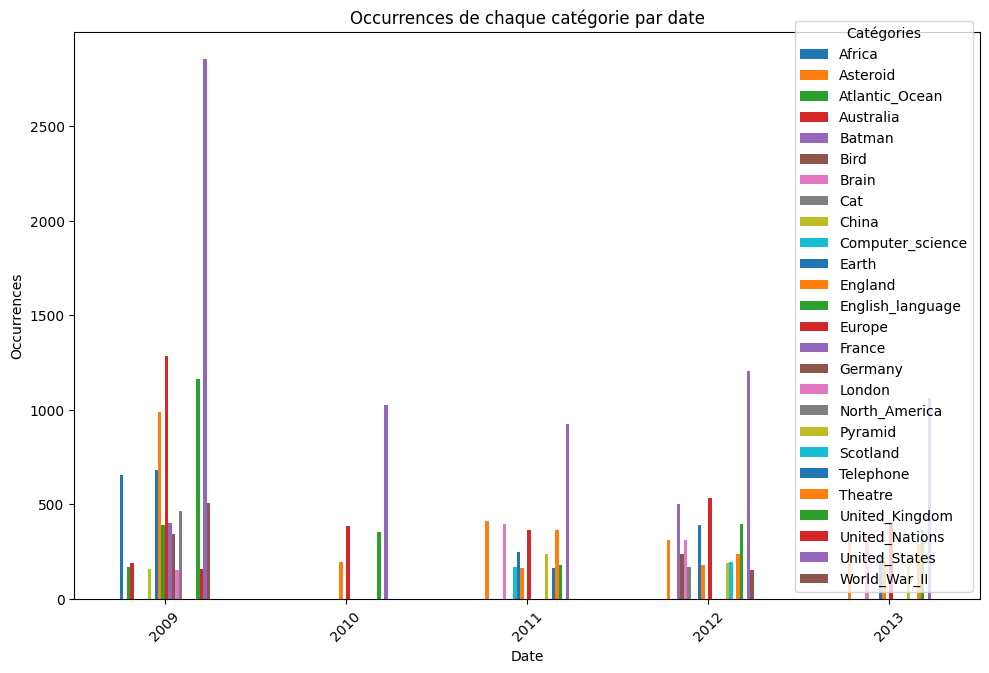

In [33]:
import matplotlib.pyplot as plt
unstacked_hub = hubs_date.unstack(level='Categories').fillna(0)
unstacked_hub.plot(kind='bar', stacked=False, figsize=(10, 7))
plt.title('Occurrences de chaque catégorie par date')
plt.xlabel('Date')
plt.ylabel('Occurrences')
plt.legend(title='Catégories')
plt.xticks(rotation=45)  # Rotation des dates sur l'axe des x pour une meilleure lisibilité
plt.tight_layout()  # Ajustement de la mise en page pour s'assurer que tout tient
plt.show()


In [34]:
#association sémantique des concepts partiel
#on commence par comparer le lien entre catégorie deux à deux
categories_link = pd.DataFrame(columns=['Occurence']) # index is of format 'Categorie1->Categorie2'
filter_path_df = paths_finishedDf['path'].str.split(';', expand=True)

for i in range(0,15000):
    temp = ''
    for j in range(0,filter_path_df.shape[1]):
        if (filter_path_df.iloc[i,j] == None): 
            break
        if (j != 0):
            categorie2 = filter_path_df.iloc[i,j]
            index = temp + '->' + categorie2
            index2 = categorie2 + '->' + temp
            if (index in categories_link.index.tolist()):
                categories_link.loc[index,'Occurence'] +=1 
            elif(index in categories_link.index.tolist()):
                categories_link.loc[index,'Occurence'] +=1 
            else : 
                categories_link.loc[index, 'Occurence'] = 1
                
        temp = filter_path_df.iloc[i,j]
            
            
            
            
categories_link

,Occurence
14th_century->Europe,4
Europe->Africa,37
Africa->Atlantic_slave_trade,10
Atlantic_slave_trade->African_slave_trade,9
14th_century->Niger,1
...,...
History_of_Earth->Computer,1
Sleep->Brain,1
<->Stroke,1
Optical_fiber->Physics,1


In [35]:
categories_link_filter = categories_link[categories_link['Occurence']>50]
categories_link_filter

,Occurence
North_America->United_States,132
United_States->President_of_the_United_States,117
Christianity->Bible,55
<-><,1298
Atlantic_Ocean->Ocean,61
...,...
Asteroid->Solar_System,72
Asteroid->Trojan_War,126
Denmark->Viking,142
Asteroid->1_Ceres,64


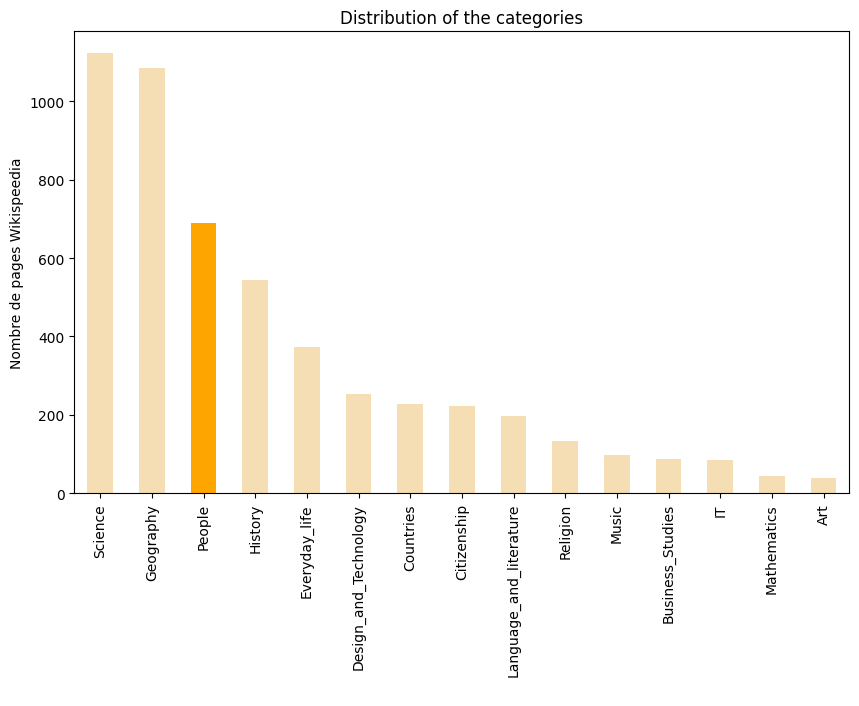

In [36]:
categories_details = categoriesDf["categories"].str.split(".", expand=True)

#keep only the main category
categories = categories_details[1]
categories = pd.DataFrame(categories)
categories = categories.rename(columns = {1 : 'Main Categories'})
categories_distribution=categories['Main Categories'].value_counts()

#Vizualise the distribution 
plt.figure(figsize=(10, 6))  
colors = ['wheat' if cat != 'People' else 'orange' for cat in categories_distribution.index]
categories_distribution.plot(kind='bar', color=colors)
plt.title('Distribution of the categories')
plt.xlabel(' ')
plt.ylabel('Nombre de pages Wikispeedia')
plt.show()


In [37]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color'].unique()
rename = {
    'Blanc' : 'White',
    'Peau plus foncée' : 'Black',
    'Peau brune' : 'East Asian',
    'Peau plus foncée (Aborigène australien)' : 'Black',
    'Peau plus foncée (Asiatique)' : 'East Asian', 
    'Peau plus foncée (Moyen-Orient)' : 'Arab',
    'Peau plus foncée (Polynésien)' : 'Polynesian',
    'Peau plus foncée (Sherpa/Népalais)' : 'South Asian', 
    'Peau plus foncée (Ascendance africaine partielle)' : 'Black', 
    'Peau plus foncée (Indien)' : 'South Asian',
    'Peau plus foncée (Berbère)' : 'Arab',
    'Peau plus foncée (Arabe)' : 'Arab',
    'Peau plus foncée (Tibétain)' : 'East Asian',
    'Peau plus foncée (Persan)' : 'Arab',
    'Peau plus foncée (Juif)' : 'Arab', 
    'Peau plus foncée (Somalienne)' : 'Black', 
    'Peau plus foncée (Mixte)' : 'Black',
    'Peau plus foncée (Hispanique)' : 'Hispanic', 
    'Peau plus foncée (Indonésien)' : 'East Asian', 
    'Peau plus foncée (Japonais)' : 'East Asian',
    'Peau plus foncée (Vietnamien)' : 'East Asian', 
    'Peau plus foncée (Indienne)' : 'South Asian', 
    'Peau brune (Indien)' : 'South Asian',
    'Peau plus foncée (Palestinien)' : 'Arab',
    'Peau brune (Pakistano-Indien)' : 'South Asian', 
    "Blanc (D'origine libanaise)": 'White', 
    'Peau plus foncée (Brésilien)' : 'Hispanic'
}
people_color['Skin Color'] = people_color['Skin Color'].replace(rename)
people_color_dist=people_color['Skin Color'].value_counts()
people_color_dist




Skin Color
White          593
Black           61
East Asian      25
Arab            11
South Asian      5
Hispanic         4
Polynesian       1
Name: count, dtype: int64

/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_48151/3584408734.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  people_dist_order = [people_color_dist[0], people_color_dist[6],people_color_dist[1],
/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_48151/3584408734.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  people_color_dist[5],people_color_dist[2],people_color_dist[4],
/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_48151/3584408734.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

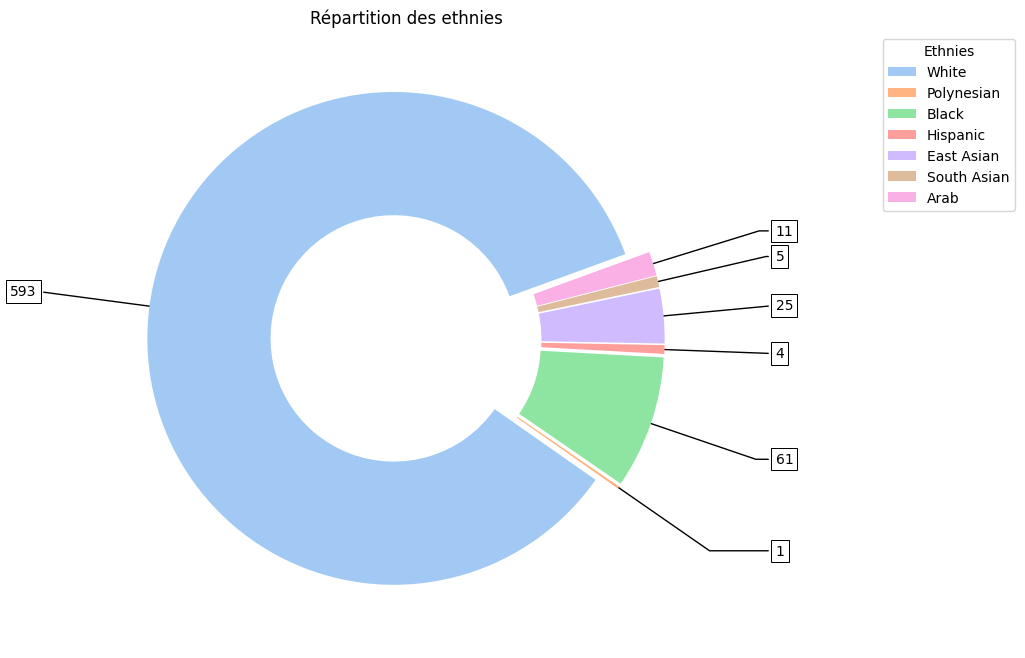

In [44]:
#Vizualise the data
labels2 = 'White', 'Polynesian', 'Black', 'Hispanic', 'East Asian', 'South Asian', 'Arab'
people_dist_order = [people_color_dist[0], people_color_dist[6],people_color_dist[1],
                     people_color_dist[5],people_color_dist[2],people_color_dist[4],
                     people_color_dist[3]]

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect='equal'))

wedges, texts = ax.pie(people_dist_order , wedgeprops=dict(width=0.5), startangle=20, explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], colors=sns.color_palette("pastel"))


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(people_dist_order[i], xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y),
                horizontalalignment=horizontalalignment, **kw)
ax.legend(wedges,labels2, title="Ethnies",bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Répartition des ethnies')
plt.show()
